In [1]:
# using CuArrays # comment me out if you don't want to use GPU
using Flux, Flows
import Distributions: rand, logpdf
import PyPlot; const plt = PyPlot
using Tracker: update!

┌ Info: Recompiling stale cache file /home/sharan/.julia/compiled/v1.1/Flows/HDEsO.ji for Flows [b7844722-a0ec-11e9-22bc-51d568b73702]
└ @ Base loading.jl:1184
┌ Warning: Package Flows does not have LinearAlgebra in its dependencies:
│ - If you have Flows checked out for development and have
│   added LinearAlgebra as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Flows
└ Loading LinearAlgebra into Flows from project dependency, future warnings for Flows are suppressed.


## Generate some data from a mixture of two Gaussians to use

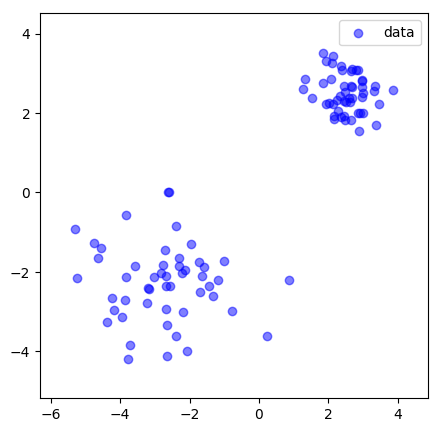

2×100 Array{Float32,2}:
 2.69262  1.84365  2.37286  2.58955  …  -3.71394  -3.2344    0.857955
 3.10267  2.74642  3.19628  2.38161     -3.83816  -2.77462  -2.20049 

In [2]:
X = randn(Float32, 2, 100)
X[:,1:50] .*= 0.5
X[:,1:50] .+= 5.0
X .-= 2.5

function makeplot(x; xgen=nothing, logpdf2plot=nothing, contourevals=100)
    p = plt.figure(figsize=(5, 5))
    plt.scatter(x[1,:], x[2,:], c="blue", alpha=0.5, label="data")
    xgen == nothing || plt.scatter(xgen[1,:], xgen[2,:], c="red", alpha=0.5, label="samples")
    xlims = [extrema(x[1,:])...] + [-1, 1]
    ylims = [extrema(x[2,:])...] + [-1, 1]
    if logpdf2plot != nothing
        rangex = range(xlims..., length=contourevals)
        rangey = range(ylims..., length=contourevals)
        gridxy = [[xy...] for xy in Iterators.product(rangex, rangey)]
        gridx = map(xy -> xy[1], gridxy)
        gridy = map(xy -> xy[2], gridxy)
        gridz = exp.(logpdf2plot(hcat(gridxy[:]...) |> gpu)) |> cpu |> Flux.data
        gridz = reshape(gridz, size(gridx)...)
        plt.contour(gridx, gridy, gridz, alpha=0.5)
        plt.colorbar()
    end
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.legend()
    nothing
end

makeplot(X)

# Send data to GPU
X = X |> gpu

## Create a normalising flow by stacking multiple layers of Planar Flows

$$ f = f_1 \circ f_2 \circ \cdots \circ f_{N-1} \circ f_N : \mathcal{Z} \rightarrow \mathcal{X}$$

We assume base distribution is the unit Gaussian, i.e. $p_{\mathcal{Z}} = \mathcal{N}(0,1)$.

In [3]:
# Define a base distribution that is easy to work with GPU
struct MvNormal01
    dim::Int
end

# The constant below is a hack to make things work on GPU.
const LOG2PI32 = log(2Float32(pi))
logpdf(d::MvNormal01, x) = sum(-(LOG2PI32 .+ x .* x) ./ 2; dims=1)
rand(d::MvNormal01, n::Int=1) = randn(Float32, d.dim, n) |> gpu

rand (generic function with 197 methods)

In [4]:
PlanarLayer <: AbstractInvertibleTransformation

true

In [5]:
DEPTH = 10
# initialize flow with dim 2 and depth 6
T = compose([PlanarLayer(2) for i in 1:DEPTH]...)
base = MvNormal01(size(X, 1))

# A normalising flow is nothing but a transformation plus a base distribution
# Check `src/flows.jl` for the abstraction
flow = Flow(T, base)

# Create optimiser

ps = params(flow)
;

## Define loss

$$\mathcal{L} = -\log p_{\mathcal{X}}(x) = -\left(\log p_{\mathcal{Z}}(f^{-1}(x)) + \log \left| \det \frac{\partial f^{-1}(x)}{\partial x} \right|\right),$$

where $f^{-1}: \mathcal{X} \rightarrow \mathcal{Z}$.

In [6]:
function logpdf(f::Flow{Composed{PlanarLayer}}, x) where {T<:AbstractInvertibleTransformation}
#     it = inv(f.t)
    res = forward(f.t, x)
    return logpdf(f.base, res.rv) + transpose(res.logabsdetjacob)
end

logpdf (generic function with 65 methods)

In [7]:
compute_loss(X) = sum(logpdf(flow, X))

compute_loss (generic function with 1 method)

## Run optimisation

In [8]:
using Flux.Tracker: update!

In [9]:
opt = ADAM(2e-3)
niters = 2_000
timeused = @elapsed for iter = 1:niters
    iter % 10 == 0 && print(".")
    for j in 1:10:size(X)[2]
        loss = compute_loss(X[:, j:(j+9)])
        gs = Tracker.gradient(() -> loss, ps)
        for p in ps
            Tracker.update!(opt, p, gs[p])
        end
    end
    loss = compute_loss(X)
    iter % 100 == 0 && println("($iter/$niters) done; loss=$loss")
end
println("done; $(timeused)s used")

..........(100/2000) done; loss=-346.87729739068055 (tracked)
..........(200/2000) done; loss=-324.07838660872756 (tracked)
..........(300/2000) done; loss=-311.3845781507522 (tracked)
..........(400/2000) done; loss=-307.97254130388376 (tracked)
..........(500/2000) done; loss=-303.52109233761666 (tracked)
..........(600/2000) done; loss=-301.94549737596446 (tracked)
..........(700/2000) done; loss=-303.3340152797165 (tracked)
..........(800/2000) done; loss=-301.6967261096378 (tracked)
..........(900/2000) done; loss=-297.9975433544365 (tracked)
..........(1000/2000) done; loss=-298.1516161774655 (tracked)
..........(1100/2000) done; loss=-295.39705084693264 (tracked)
..........(1200/2000) done; loss=-291.44568067889236 (tracked)
..........(1300/2000) done; loss=-291.7580122639125 (tracked)
..........(1400/2000) done; loss=-290.54013844853284 (tracked)
..........(1500/2000) done; loss=-289.65333850743184 (tracked)
..........(1600/2000) done; loss=-289.0341820108083 (tracked)
........

## Draw samples

$$ z \sim \mathcal{N}(0,1) $$
$$ x = f(z) $$

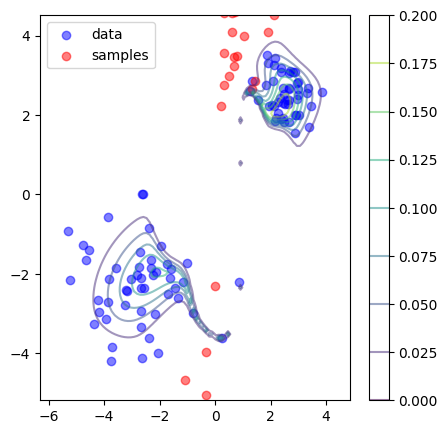

In [10]:
# Draw 100 samples from the normalising flow
Xgen = rand(flow, 100) |> cpu |> Flux.data

makeplot(X; xgen=Xgen, logpdf2plot=x -> logpdf(flow, x))